# School Bus Optimization Problem

### Problem formulation

A school needs to transport N students to the zoo using different kind of buses. There are three types of buses available for capacity and cost:

- A, 35 seats, 300€ each
- B, 49 students, 400€ each
- C, 57 students, 450€ each

The objective is to minimize the total cost of buses while transporting all students.

### Assumptions

- All students must be transported
- Buses can operate below capacity but at the same cost, regardless of the number of the occupied places
- Occupied seats are an integer number

### Approach

We will compare different scenarios to find the cost-effective solution:

- Trivial solutions: using only buses A, B, C
- Educated guess starting from a practical hypothesis
- Combining both types of buses for an optimal solution (linear programming)
- Verifying with an iterative solution

### Performance

Each option is implemented in the `BusAllocation` class of th `optimization.core.bus_allocation` module. The `time_measure`, `performance_measure` and `print_output` functions are used as decorators to helps estimating time and memory usage, to be taken into consideration for a scalable solution.

### Case 1

An easy scenario is taken to demonstrate the procedure (N=123)
 
### Case 2

A more sophisticated scenario (N>>1) is shown to show how for large problems, the best solution is linear programming

# Case 1

In [1]:
from optimization.core.bus_allocation import BusAllocation

# Define constants
n_students = 321

seat_a = 35
cost_a = 300

seat_b = 49
cost_b = 400

seat_c = 57
cost_c = 450

# Create instance of the custom-made BusAllocation class
bus_allocator = BusAllocation((seat_a, seat_b, seat_c), (cost_a, cost_b, cost_c), n_students)

### Options 1-3: Trivial Solutions

If we use only buses A, B or C the results are:

- A required: n_students/seat_a = 36 $\Rightarrow$ 1200€
- B required: n_students/seat_b = 26 $\Rightarrow$ 1200€
- C required: n_students/seat_c = 22 $\Rightarrow$ 1350€

Options 1 and 2 are equivalent.

In [2]:
option_1 = bus_allocator.trivial_solution('A')
option_2 = bus_allocator.trivial_solution('B')
option_3 = bus_allocator.trivial_solution('C')

(A, B, C) = (10, 0, 0)
Minimum total cost: 3000€
(A, B, C) = (0, 7, 0)
Minimum total cost: 2800€
(A, B, C) = (0, 0, 6)
Minimum total cost: 2700€


### Option 4: Educated Guess

Intuitively, the price of one seat is lower for larger coaches. The prices per seat are:

- A: cost_a/seat_a = 8.57 €/seat
- B: cost_b/seat_b = 8.16 €/seat
- C: cost_c/seat_c = 7.89 €/seat

Thus, we can make an educated guess and fill up as many C buses as possible, before moving to B buses, and finally fill A kind. This can bring us very close to the optimal solution.

In [3]:
option_4 = bus_allocator.educated_guess()

(A, B, C) = (2, 0, 5)
Minimum total cost: 2850€


### Option 5: Linear programming
    
This is a method to achieve the best outcome in a mathematical model whose requirements and objective are represented by linear relationships.
We need to introduce a cost function: 
  
$$ f(x,y,z) = xX + yY + zZ$$

where (x,y,z) are the number of A-, B- and C-buses, and (X, Y, Z) are their unitary price. 

We will prefer the `pulp` library to the most common `scipy.optimize.linprog` since the latter does not directly support integer programming, which includes constraining variables to be integers. 

In [4]:
option_5 = bus_allocator.linear_programming()
option_5

(A, B, C) = (0, 2, 4)
Minimum total cost: 2600.0€


{'A': 0,
 'B': 2,
 'C': 4,
 'minimum_total_cost': 2600.0,
 'current': 63383,
 'peak': 181162,
 'elapsed_time': 22.31144905090332}

### Option 6: Checking all solutions

One possibile solution in optimization problems is to check all possible solutions. This method is practicably unfeaseble for large problems, although is useful to conjecture the quality of another method in small dimensions. In `iterative_solution`, we can enumerate all possibilities and choose the one minimizing the overall cost.

In [5]:
option_6 = bus_allocator.iterative_solution()
true_lowest_cost = option_6['minimum_total_cost']
option_6

(A, B, C) = (0, 2, 4)
Minimum total cost: 2600€


{'A': 0,
 'B': 2,
 'C': 4,
 'minimum_total_cost': 2600,
 'current': 2072,
 'peak': 3048,
 'elapsed_time': 1.2421607971191406}

### Case 1 - Comparing the results

Below, we can compare the results coming from the different methods:
- `minimum_total_cost`: given that the true lower cost is the one form `option_6`, we can compare the difference wrt this value. Note that only `linear_program` is able to find the best solution
- `elapsed_time`: if we discard the trivial solutions `(1-3)`, for case 1 the `educated_guess` and the `iterative_solutions` are quite fast
- memory wise, the `peak` also shows that `linear_program` uses quite a lot, altohoug it's the only one finding the right solution


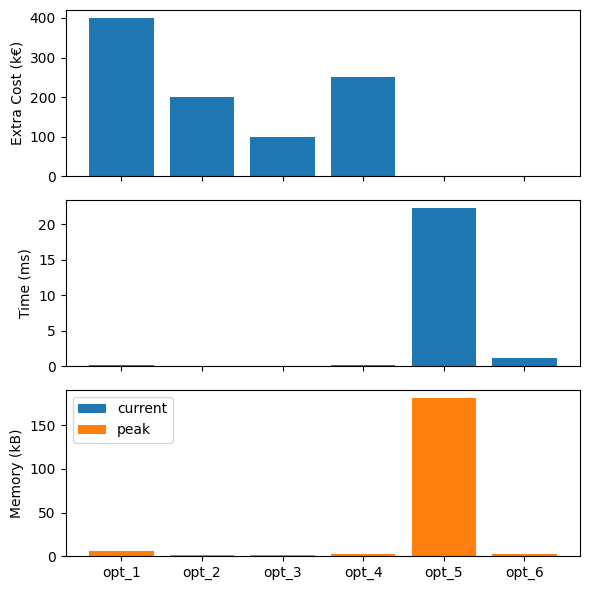

In [6]:
import matplotlib.pyplot as plt

all_options = [option_1, option_2, option_3, option_4, option_5, option_6] 
fig, ax = plt.subplots(3,1, sharex=True, figsize=(6,6))

labels = [f'opt_{i}' for i in range(1,7)]
ax[0].bar(labels, [ (opt['minimum_total_cost']-true_lowest_cost) for opt in all_options ])
ax[1].bar(labels, [ opt['elapsed_time'] for opt in all_options ])
ax[2].bar(labels, [ opt['current']/1000 for opt in all_options ], label = 'current')
ax[2].bar(labels, [ opt['peak']/1000 for opt in all_options ], label='peak')
ax[2].legend()

ax[0].set_ylabel('Extra Cost (k€)')
ax[1].set_ylabel('Time (ms)')
ax[2].set_ylabel('Memory (kB)')

plt.tight_layout()

# Case 2

Let us now study how the performance of `educated_guess`, `linear_programming` and `iterative_solution` vary with the size of the problem. We take logarithmic increase steps and compare the evolution of time and memory. 

In [22]:
import numpy as np

n_students_list = np.logspace(2, 4, 5)
n_students_list

array([  100.        ,   316.22776602,  1000.        ,  3162.27766017,
       10000.        ])

### educated_guess 

In [31]:
opt_eg_list = []

for n_students in n_students_list:
    bus_allocator = BusAllocation(
        (seat_a, seat_b, seat_c), 
        (cost_a, cost_b, cost_c), 
        int(n_students))
    opt_eg = bus_allocator.educated_guess()
    opt_eg_list.append(opt_eg)

(A, B, C) = (2, 0, 1)
Minimum total cost: 1050€
(A, B, C) = (1, 0, 5)
Minimum total cost: 2550€
(A, B, C) = (1, 0, 17)
Minimum total cost: 7950€
(A, B, C) = (1, 0, 55)
Minimum total cost: 25050€
(A, B, C) = (1, 0, 175)
Minimum total cost: 79050€


### linear_programming 

In [32]:
opt_lp_list = []

for n_students in n_students_list:
    bus_allocator = BusAllocation(
        (seat_a, seat_b, seat_c), 
        (cost_a, cost_b, cost_c), 
        int(n_students))
    opt_lp = bus_allocator.linear_programming()
    opt_lp_list.append(opt_lp)

(A, B, C) = (0, 1, 1)
Minimum total cost: 850.0€
(A, B, C) = (1, 0, 5)
Minimum total cost: 2550.0€
(A, B, C) = (1, 0, 17)
Minimum total cost: 7950.0€
(A, B, C) = (1, 1, 54)
Minimum total cost: 25000.0€
(A, B, C) = (1, 1, 174)
Minimum total cost: 79000.0€


### iterative_solution

In [33]:
opt_is_list = []

for n_students in n_students_list:
    bus_allocator = BusAllocation(
        (seat_a, seat_b, seat_c), 
        (cost_a, cost_b, cost_c), 
        int(n_students))
    opt_is = bus_allocator.iterative_solution()
    opt_is_list.append(opt_is)

(A, B, C) = (0, 1, 1)
Minimum total cost: 850€
(A, B, C) = (0, 3, 3)
Minimum total cost: 2550€
(A, B, C) = (0, 3, 15)
Minimum total cost: 7950€
(A, B, C) = (1, 1, 54)
Minimum total cost: 25000€
(A, B, C) = (0, 4, 172)
Minimum total cost: 79000€


### Case 2 - Comparing the results

Below, we compare the evolution of `minimum_total_cost`, `elapsed_time` and memory `peak` with the size of the student. Note that the results for time and peak are dependent on the machine that is used.

- `linear_programming` is the algorithm that finds the best solution in the smaller time
- `educated_guess` often cannot find the optimal solution, despite being the method requiring less time and memory
- `iterative_solution` require a time exponentially large with respect to the other two methods.


In [38]:
opt_eg_costs = [ d['minimum_total_cost'] for d in opt_eg_list ]
opt_eg_memory = [ d['peak'] for d in opt_eg_list ]
opt_eg_times = [ d['elapsed_time'] for d in opt_eg_list ]

opt_lp_costs = [ d['minimum_total_cost'] for d in opt_lp_list ]
opt_lp_memory = [ d['peak'] for d in opt_lp_list ]
opt_lp_times = [ d['elapsed_time'] for d in opt_lp_list ]

opt_is_costs = [ d['minimum_total_cost'] for d in opt_is_list ]
opt_is_memory = [ d['peak'] for d in opt_is_list ]
opt_is_times = [ d['elapsed_time'] for d in opt_is_list ]


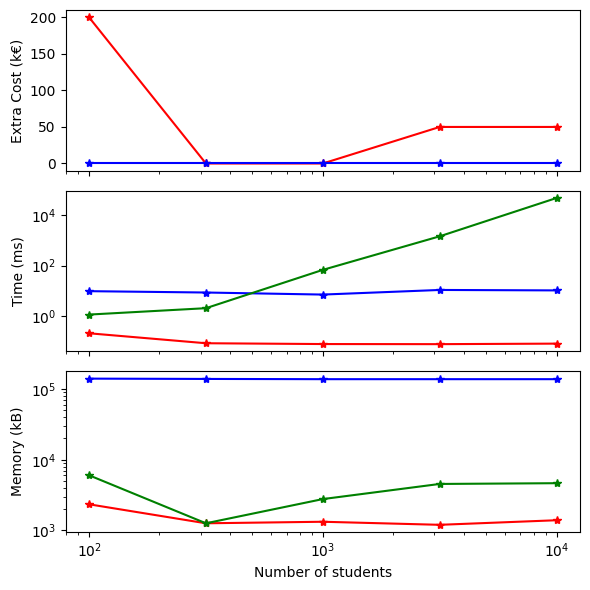

In [51]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(6,6))

ax[0].semilogx(n_students_list, [ a-b for (a,b) in zip(opt_eg_costs, opt_is_costs)], '-*r')
ax[0].semilogx(n_students_list, [ a-b for (a,b) in zip(opt_lp_costs, opt_is_costs)], '-*b')

ax[1].loglog(n_students_list, opt_eg_times, '-*r')
ax[1].loglog(n_students_list, opt_lp_times, '-*b')
ax[1].loglog(n_students_list, opt_is_times, '-*g')

ax[2].loglog(n_students_list, opt_eg_memory, '-*r')
ax[2].loglog(n_students_list, opt_lp_memory, '-*b')
ax[2].loglog(n_students_list, opt_is_memory, '-*g')

ax[0].set_ylabel('Extra Cost (k€)')
ax[1].set_ylabel('Time (ms)')
ax[2].set_ylabel('Memory (kB)')
ax[2].set_xlabel('Number of students')

plt.tight_layout()

# Conclusion

`linear_programming` is the algorithm that finds the best solution in the smaller time